# Import de librerias

In [230]:
import json
import os
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, md5, sum, when 

In [14]:
spark = SparkSession.builder.appName("Desafio").getOrCreate()

# Definiciones: Variables, constantes, estructuras

In [231]:
COMPRESSION_FORMAT = "gzip"
PARTITION_COLUMN = "date"

ROOT_INPUT_DIR = "inputs"
FILES_DIR = "csv"

EVENTS_FILE_NAME = "events.csv"
FREE_DEST_FILE_NAME = "free_destinations.csv"

OUTPUT_FILE_NAME = "top_100_facturacion.parquet"

TITLE_X = "Hora del día"
TITLE_Y = "Cantidad de llamadas"
TITLE = "Histograma de llamadas por hora del día"

In [187]:
events_path = os.path.join(ROOT_INPUT_DIR, FILES_DIR, EVENTS_FILE_NAME)
free_path = os.path.join(ROOT_INPUT_DIR, FILES_DIR, FREE_DEST_FILE_NAME)
config_path = os.path.join(ROOT_INPUT_DIR, "config.json")

# Funsionces

In [232]:
def joins(eventos, free_target, costos):
    df_eventos_ok = eventos.filter((col("id_source").isNotNull()) & (col("id_destination").isNotNull()))
    df_eventos_pricing = df_eventos_ok.join(costos, costos.nro_region == df_eventos_ok.region)
    df_free_target = free_target.withColumn("flag_free", lit(1))

    df = df_eventos_pricing.join(df_free_target, df_eventos_ok.id_destination == df_free_target.id, "left") \
    .drop("id", "id_destination")

    return df

In [233]:
def facturacion(df):
    # El enunciado no lo especifica, supongo que el precio por llamada es igual al precio por sms (pero no hay bonificacion)
    df_full_pricing = df.withColumn(
        "facturacion_sms", when(col("flag_free") == 1, lit(0)).otherwise(col("sms") * col("precio"))) \
        .withColumn("facturacion_calls", col("calls") * col("precio"))

    df_fact = df_full_pricing.withColumn("facturacion_total", col("facturacion_sms") + col("facturacion_calls"))

    return df_fact

In [234]:
def tranform(eventos, free_target, costos):
    df_join = joins(eventos, free_target, costos)
    df_facturacion = facturacion(df_join)
    df_hash = df_facturacion.withColumn("id_hash", md5("id_source"))

    return df_hash

# Lectura de datos

In [235]:
# Este archivo es un ejemplo de guardado de datos fuera del ejecutable para sean facilmente modificables.
with open(config_path) as f:
    config_file_js = json.load(f)

In [236]:
rows_limit = config_file_js["rows_limit"]

In [237]:
df_costos = spark.createDataFrame(config_file_js["cost"])
df_costos.cache()

DataFrame[nro_region: bigint, precio: double]

In [238]:
df_eventos = spark.read.csv(events_path, header = True, inferSchema = True)

In [239]:
df_free_target = spark.read.csv(free_path, header = True, inferSchema = True)

# Transformacion

In [240]:
df = tranform(df_eventos, df_free_target, df_costos)

### Calcular el monto total que facturará el proveedor del servicio por envíos de sms.

In [241]:
df.select(sum('facturacion_sms').alias("facturacion_total_sms")).show()

+---------------------+
|facturacion_total_sms|
+---------------------+
|             391367.0|
+---------------------+



# Guardado

### Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip.

In [242]:
df.orderBy("facturacion_sms", ascending = False) \
    .select(col("id_source"), col("id_hash"), col("facturacion_total")) \
    .limit(rows_limit) \
    .write.mode("overwrite") \
    .parquet(OUTPUT_FILE_NAME, compression = COMPRESSION_FORMAT)

# en caso de que necesite particionar salida se puede agregar .partitionBy(PARTITION_COLUMN) a la sentencia.

# Grafico

### Graficar un histograma de cantidad de llamadas que se realizan por hora del día.

In [243]:
df_calls_by_hour = df.groupBy("hour").agg(sum("calls").alias("total_llamadas"))
df_pd = df_calls_by_hour.toPandas()

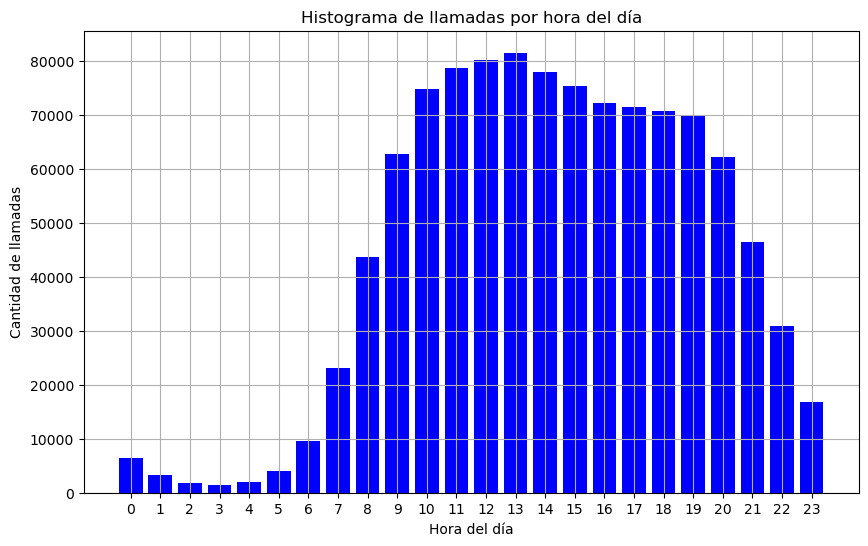

In [244]:
plt.figure(figsize=(10, 6))
plt.bar(df_pd["hour"], df_pd["total_llamadas"], color = 'blue')
plt.xlabel(TITLE_X)
plt.ylabel(TITLE_Y)
plt.title(TITLE)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()